2DOF :  2 angles
Circular obstacles that it cannot bump into
1. Calculate config space for these two robots 
2. Make arms rectangular 
3. You can decide length and width of arms
4. 3 spheres obstacles -> you decide diameter and location
5. Calculate configuration space by randomly sampling and see if it collides
    1. Sample every combination 
    2. Get an image  - > (workspace, config_space)
6.  Train from work space to estimate config space
    1. See if shape 


In [1]:
import math
from shapely.geometry import Polygon,Point,LineString,MultiPoint
from shapely import affinity
import matplotlib.pyplot as plt

In [20]:
def round_point(point):
    return Point(round(point.x,4),round(point.y,4))

def round_polygon(ls):
    linestring = []
    for point in ls.exterior.coords:
        linestring.append(Point(round(point[0],4),round(point[1],4)))
    return MultiPoint(linestring).convex_hull

def round_line_string(ls):
    linestring = []
    for point in ls.boundary.geoms:
        linestring.append(Point(round(point.x,4),round(point.y,4)))
    return LineString(linestring)

def get_upper_joint(rot,possible_joints):
    joint = None
    if rot == 0:
        joint = sorted(possible_joints, key= lambda x : x[1])[0]
    elif 0 < rot < 180:
        joint = sorted(possible_joints,key=lambda x: -x[0])[0]
    elif rot == 180:
        joint = sorted(possible_joints,key=lambda x: -x[1])[0]
    elif 180 < rot < 360:
        joint = sorted(possible_joints,key=lambda x: x[0])[0]
    return joint

In [21]:
robot_arm1_og = MultiPoint(list([Point(2,0),Point(4,0),Point(2,.5),Point(4,.5)])).convex_hull
total_arm_og = MultiPoint(list([Point(2,0),Point(6,0),Point(2,.5),Point(6,.5)])).convex_hull
obst_1 = Point(4,1).buffer(.5)
obst_2 = Point(0,0).buffer(.5)
obst_3 = Point(2,4).buffer(.5)

obstacles = [obst_1,obst_2,obst_3]

In [4]:
import math
from shapely.geometry import LineString,MultiPoint,Point,mapping
import matplotlib.pyplot as plt
from shapely import affinity

# two functions for plotting
def plot_coords(coords):
    pts = list(coords)
    x, y = zip(*pts)
    plt.plot(x,y)

def plot_polys(polys):
    for poly in polys:
        plot_coords(poly.exterior.coords)
        plt.fill_between(*poly.exterior.xy, alpha=.5)

def plot(q1,q2):
    arm_1_rot = q1
    arm1_joint = (2,0)
    robot_arm1 = round_polygon(affinity.rotate(robot_arm1_og,arm_1_rot,arm1_joint))
    total_a = round_polygon(affinity.rotate(total_arm_og,arm_1_rot,arm1_joint))

    total_a_coords = set([*total_a.exterior.coords])
    arm_1_coords = set([*robot_arm1.exterior.coords])
    upper_arm_coords = total_a_coords.difference(arm_1_coords).union(arm_1_coords.difference(total_a_coords))
    upper_arm = MultiPoint(list(upper_arm_coords)).convex_hull

    poossible_joints = list(arm_1_coords.intersection(upper_arm_coords))

    upper_arm_joint = get_upper_joint(arm_1_rot,poossible_joints)

    upper_arm_rotate = affinity.rotate(upper_arm,-q2,upper_arm_joint)

    fig,ax = plt.subplots(figsize=(5,5))
    ax.fill(*robot_arm1.exterior.xy,color='green')
    ax.plot(arm1_joint[0],arm1_joint[1],marker="o",markerfacecolor="black")
    ax.plot(upper_arm_joint[0],upper_arm_joint[1],marker="o",markerfacecolor="black")
    ax.fill(*upper_arm_rotate.exterior.xy,color='blue')

    ax.set_title("Work Space")
    ax.set_xlim([-3,8])
    ax.set_ylim([-5,5])
    # ax.set_aspect( 1 )
    plot_polys(obstacles)
    plt.grid()

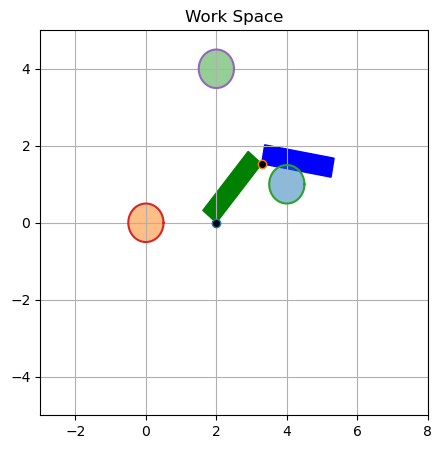

In [5]:
plot(50,60 )

In [6]:
def calculate_cobs_iter(c_robot_arm1,c_total_arm,q_1,q_2,obst,ref_pt):
    c_pts = []
    for i in q_1:
        c_arm_1_rotated = round_polygon(affinity.rotate(c_robot_arm1,i,ref_pt))
        c_total_arm_rotated = round_polygon(affinity.rotate(c_total_arm,i,ref_pt))

        c_total_arm_coords = {*c_total_arm_rotated.exterior.coords}
        c_arm_1_rotated_coords = {*c_arm_1_rotated.exterior.coords}
        c_upper_arm_coords = c_total_arm_coords.difference(c_arm_1_rotated_coords).union(c_arm_1_rotated_coords.difference(c_total_arm_coords))
        c_upper_arm = MultiPoint(list(c_upper_arm_coords)).convex_hull

        c_possible_joints = list(c_arm_1_rotated_coords.intersection(c_upper_arm_coords))
        c_upper_arm_joint = get_upper_joint(i,c_possible_joints)

        for j in q_2:
            c_arm_2_rotated = round_polygon(affinity.rotate(c_upper_arm,j,c_upper_arm_joint))
            # if type(c_arm_2_rotated.intersection(c_arm_1_rotated)) != LineString:
            #     c_obs_pts.append((i,abs(j)))
            #     break
            for o in obst:
                if c_arm_2_rotated.intersects(o) or c_arm_1_rotated.intersects(o):
                    c_pts.append((i,abs(j)))
                    break
    return c_pts


In [7]:
c_obs_pts = calculate_cobs_iter(robot_arm1_og,total_arm_og,[45,50,90],[0,-25,-60],obstacles,(2,0))
print(c_obs_pts)

[(45, 60), (50, 60), (90, 0), (90, 25)]


In [10]:
import math
from shapely.geometry import LineString,MultiPoint,Point,mapping
import matplotlib.pyplot as plt
from shapely import affinity

def plot_collision(q1,q2,title):
    # two functions for plotting
    def plot_coords(coords):
        pts = list(coords)
        x, y = zip(*pts)
        plt.plot(x,y)

    def plot_polys(polys):
        for poly in polys:
            plot_coords(poly.exterior.coords)
            plt.fill_between(*poly.exterior.xy, alpha=.5)

    robot_arm1_og = MultiPoint(list([Point(2,0),Point(4,0),Point(2,.5),Point(4,.5)])).convex_hull
    total_arm_og = MultiPoint(list([Point(2,0),Point(6,0),Point(2,.5),Point(6,.5)])).convex_hull
    arm_1_rot = q1
    arm1_joint = (2,0)
    robot_arm1 = round_polygon(affinity.rotate(robot_arm1_og,arm_1_rot,arm1_joint))
    total_a = round_polygon(affinity.rotate(total_arm_og,arm_1_rot,arm1_joint))

    total_a_coords = set([*total_a.exterior.coords])
    arm_1_coords = set([*robot_arm1.exterior.coords])
    upper_arm_coords = total_a_coords.difference(arm_1_coords).union(arm_1_coords.difference(total_a_coords))
    upper_arm = MultiPoint(list(upper_arm_coords)).convex_hull

    poossible_joints = list(arm_1_coords.intersection(upper_arm_coords))

    upper_arm_joint = get_upper_joint(arm_1_rot,poossible_joints)

    upper_arm_rotate = affinity.rotate(upper_arm,-q2,upper_arm_joint)

    fig,ax = plt.subplots(figsize=(5,5))
    ax.plot(*robot_arm1.exterior.xy,color='green')
    ax.plot(arm1_joint[0],arm1_joint[1],marker="o",markerfacecolor="black")
    ax.plot(upper_arm_joint[0],upper_arm_joint[1],marker="o",markerfacecolor="black")
    ax.plot(*upper_arm_rotate.exterior.xy,color='green')


    ax.set_title("Work Space")
    ax.set_xlim([-3,8])
    ax.set_ylim([-5,5])
    ax.set_title(title)
    # ax.set_aspect( 1 )
    plot_polys(obstacles)
    plt.grid()

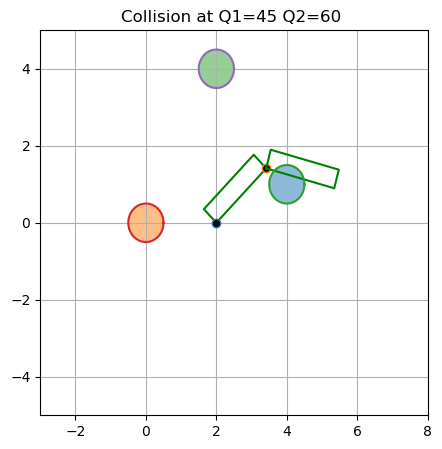

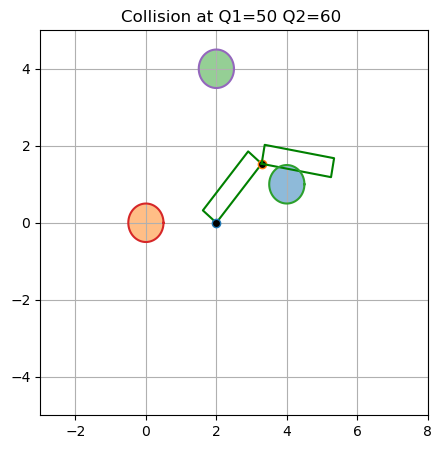

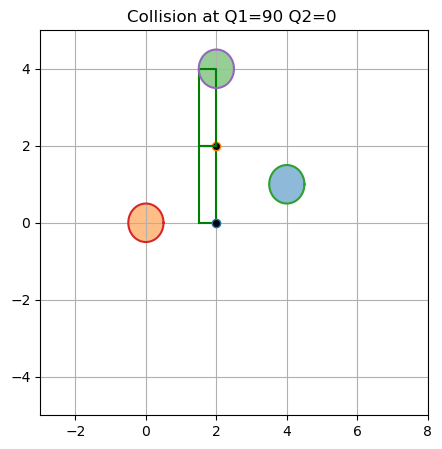

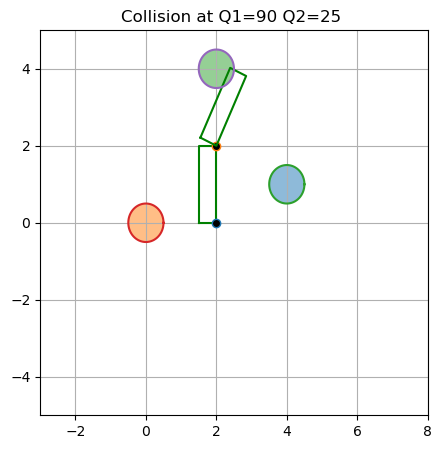

In [11]:
for collision in c_obs_pts:
    q1 = collision[0]
    q2 = collision[1]
    plot_collision(collision[0],collision[1],title=f"Collision at Q1={q1} Q2={q2} ")

In [22]:
def calculate_c_obs(c_robot_arm1,c_total_arm,q_1,q_2,obst,ref_pt):
    c_pts = []
    for i in range(q_1[0],q_1[1]+1):
        c_arm_1_rotated = round_polygon(affinity.rotate(c_robot_arm1,i,ref_pt))
        c_total_arm_rotated = round_polygon(affinity.rotate(c_total_arm,i,ref_pt))

        c_total_arm_coords = {*c_total_arm_rotated.exterior.coords}
        c_arm_1_rotated_coords = {*c_arm_1_rotated.exterior.coords}
        c_upper_arm_coords = c_total_arm_coords.difference(c_arm_1_rotated_coords).union(c_arm_1_rotated_coords.difference(c_total_arm_coords))
        c_upper_arm = MultiPoint(list(c_upper_arm_coords)).convex_hull

        c_possible_joints = list(c_arm_1_rotated_coords.intersection(c_upper_arm_coords))
        assert len(c_possible_joints) == 2, f"{i},{j}"
        c_upper_arm_joint = get_upper_joint(i,c_possible_joints)

        for j in range(q_2[0],q_2[1]-1,-1):
            c_arm_2_rotated = round_polygon(affinity.rotate(c_upper_arm,j,c_upper_arm_joint))
            # if type(c_arm_2_rotated.intersection(c_arm_1_rotated)) != LineString:
            #     c_obs_pts.append((i,abs(j)))
            #     break
            for o in obst:
                if c_arm_2_rotated.intersects(o) or c_arm_1_rotated.intersects(o):
                    c_pts.append((i,abs(j)))
                    break
    return c_pts

In [23]:
c_obs = calculate_c_obs(robot_arm1_og,total_arm_og,[0,359],[0,-179],obstacles,(2,0))

In [24]:
print(len(c_obs))

25445


[]

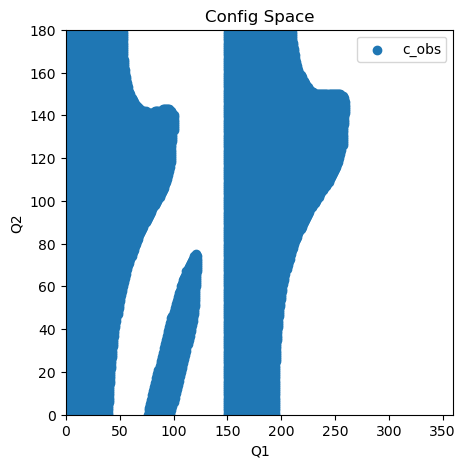

In [25]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(5,5))
ax.set_title("Config Space")
ax.set_xlim([0,360])
ax.set_ylim([0,180])
ax.set_xlabel('Q1')
ax.set_ylabel('Q2')
x_s = list(map(lambda pt: pt[0],c_obs))
y_s = list(map(lambda pt: pt[1],c_obs))
ax.scatter(x_s,y_s,label='c_obs')
ax.legend()
plt.plot()